Implementation of [this paper](https://arxiv.org/abs/1511.06434)

Modified from [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) 
but the implementation for the generator in this link is not the same as the above paper.

### Generative Adversarial Network (GAN)
As the name suggests GANs are made up of two "adversaries", a generator __G__ and a discriminator __D__.
Given a dataset __L__, the generator creates a new (random) sample __z__ and the discriminator decides if __z__ belongs to the dataset __L__

What makes GANs useful is that __G__ "learns" to generate samples that can fool __D__ into believing they belong to __L__

This is a two player game whose __equilibrium__ is when __G__ can generate  samples "indistinguishable" from the ones in __L__ and __D__  does not have more than a 50% chance of detecting "fakes"

Let $p_{data}$ be the (unknown) distribution of data from which we have a data set $L\subset \mathbb{R}^n$. Let $p_z$ be a distribution of random variables $z$ such that $z\in\mathbb{R}^d$. The generator G is then a map $G:\mathbb{R}^d\rightarrow \mathbb{R}^n$ and the discriminator $D:\mathbb{R}^n\rightarrow [0,1]$.

The generator $G$ implicitly defines a distribution $p_g$ where $x\sim p_g\Leftrightarrow x=G(z),z\sim p_z$

The discriminator wants to maximise its ability to discriminate between $x\in L$ and $x=G(z)$ with $z\sim p_z$. In other words, the best discriminator would have $D(x)=1$ for $x\sim p_{data}$ and $D(G(z))=0$ for $z\sim p_z$. On the other hand, $G$ wants to minimise the ability of the discriminator to distinguish between $x\sim p_{data}$ and $x\sim p_g$.

To accomplish the above [Goodfellow et. al](https://arxiv.org/abs/1406.2661) propose the following two player game __minimax__ game between $D$ and $G$

$$
\min_G\max_D V(D,G)=\mathbb{E}_{x\sim p_{data}}[\log D(x)]+\mathbb{E}_{z\sim p_z}[\log(1-D(G(z)))]

$$

It is shown in [Goodfellow et. al](https://arxiv.org/abs/1406.2661) that the solution to the game gives $p_g=p_{data}$ and $D(x)=1/2$

### Implementation

The maps $G$ and $D$ are implemented using neural networks where $D$ is a binary classifier and $G:\mathbb{R}^d\rightarrow \mathbb{R}^n$ with $d$ the dimension of the random samples and $n$ the dimension of the elements in the dataset

In [1]:
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize,Compose
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import yaml
from munch import DefaultMunch
from collections import defaultdict
from utils import random_sample,init_weight
from tqdm.notebook import tqdm
from networks import Generator, Discriminator

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
cfg_path = './config.yml'
with open(cfg_path, "r") as f:
    print(f"Loading config file: {cfg_path}")
    cfg = yaml.safe_load(f)
cfg = DefaultMunch.fromDict(cfg)

Loading config file: ./config.yml


Data downloaded from [here](https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=drive_link&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ)

In [3]:
# nf_g=2*cfg.img_size
# nf_d=cfg.img_size

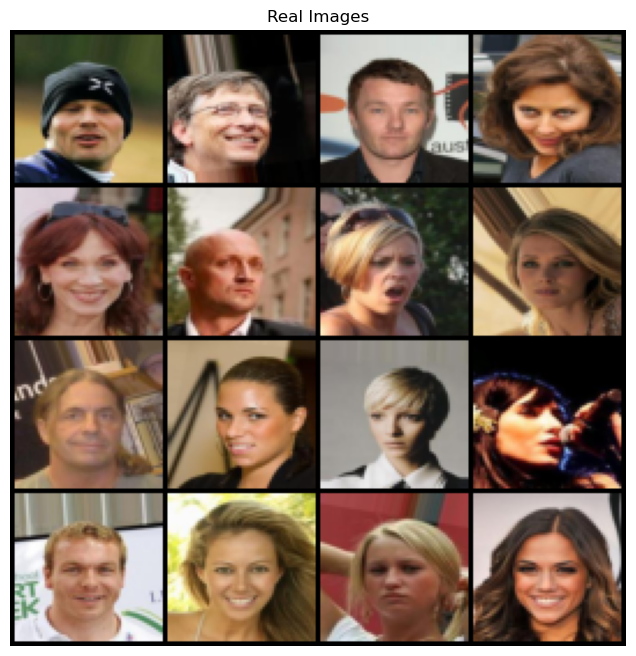

In [4]:
dataset =ImageFolder(root=cfg.data_dir,
                           transform=Compose([
                               Resize((cfg.img_size,cfg.img_size)),
                               ToTensor(),
                               Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.batch_size,
                                         shuffle=True, num_workers=cfg.workers)

# a batch contains images and labels (same label for all images)
real_images,_ = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_images.to(cfg.device)[:16],nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

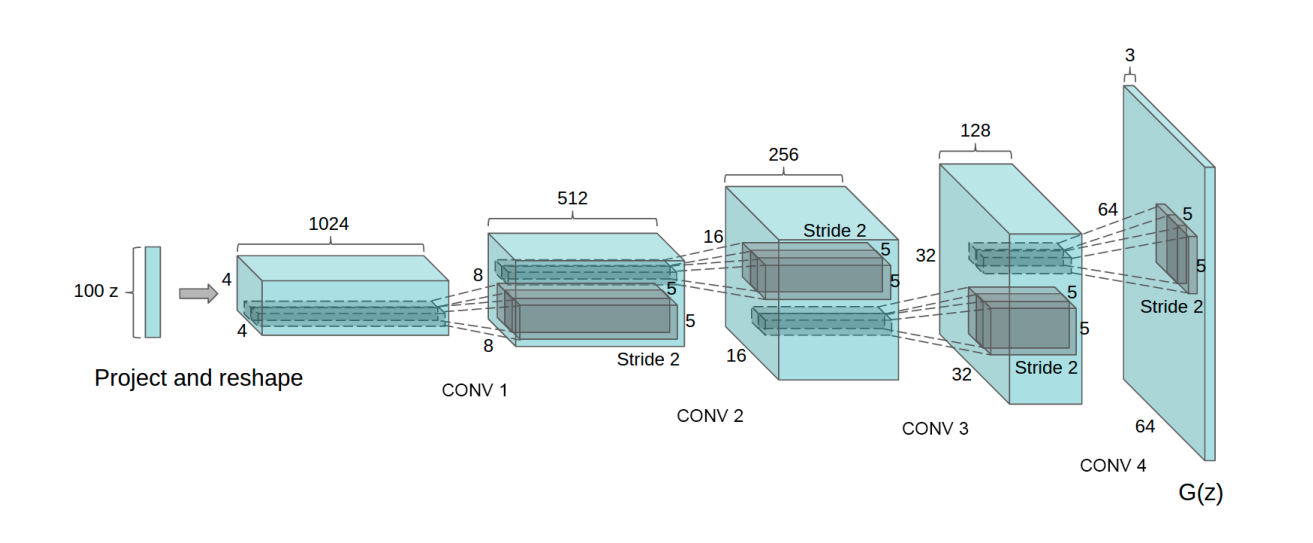

For an introduction to Convolution transpose see [here](http://d2l.ai/chapter_computer-vision/transposed-conv.html)
```
torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0,..., bias=True,...)
```
For input $(N,C_{in},H_{in},W_{in})$ and $(N,C_{out},H_{out},W_{out})$

Assuming the default padding=0, dilation=1 and output padding=0 we get

$H_{out}=H_{in}+K_H-1 $ and 

$W_{out}=W_{in}+K_W-1 $

For situation other than defaults see [here](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) 
When dilation=0 and output padding=0
$H_{out}=(H_{in}-1)\times stride_H -2\times padding_H+K_H $


In [5]:
#input=torch.randn((cfg.batch_size,cfg.zdim,1,1))
# input=random_sample(cfg.batch_size,cfg.zdim,device=cfg.device)
# input.size()

In [6]:
# layer=nn.ConvTranspose2d(cfg.zdim,nf_g*8,4,1,0,bias=False).to(cfg.device)
# output=layer(input)
# output.size()

In [7]:

generator = Generator(cfg.img_size,cfg.img_ch,cfg.zdim,cfg.g_norm_type,cfg.g_final_activation).to(cfg.device)
generator.apply(init_weight)
discrim = Discriminator(cfg.img_size,cfg.img_ch,cfg.d_norm_type,cfg.d_final_activation).to(cfg.device)
discrim.apply(init_weight)

criterion = nn.BCELoss()
fixed_noise = random_sample(16,cfg.zdim,device=cfg.device)

optD = optim.Adam(discrim.parameters(), lr=cfg.lr.d, betas=(0.5, 0.999))
optG = optim.Adam(generator.parameters(), lr=cfg.lr.g, betas=(0.5, 0.999))

In [8]:
def discriminator_step(imgs):
    ############################
        # (1) Train D network: maximize log(D(x)) + log(1 - D(G(z)))
        # i.e., minimize ``-log(D(x)) - log(1 - D(G(z)))``
        # To do the minimisation we will use BCELoss
        # BCELoss(output,target) computes the average over a batch of
        # target*log(output)+(1-target)*log(1-output)
        # so to compute log(output) we call BCELoss(output,ones_like(output))
        # and to compute log(1-output) we call BCELoss(output,zeros_like(output))
    ###########################
    
    #noise = torch.randn(cfg.batch_size, cfg.zdim, 1, 1, device=cfg.device)
    noise = random_sample(cfg.batch_size,cfg.zdim,device=cfg.device)
    fake = generator(noise)
   
    imgs = imgs.to(cfg.device)
    output = discrim(imgs)    
    # compute log(D(x))
    discrim.zero_grad()
    d_loss_real = criterion(output, torch.ones_like(output))
    d_loss_real.backward()
    # compute log(1-D(G(z))) via log(D(G(z))
    # use .detach() to return a leaf tensor that is no longer
    # connected to the graph of the generator otherwise the backpropagation
    # below will update the generator weights
    output = discrim(fake.detach())
    d_loss_fake = criterion(output, torch.zeros_like(output))
    d_loss_fake.backward()
    
    d_loss = d_loss_real + d_loss_fake
    optD.step()
    return d_loss

In [9]:
def generator_step():
    #Update G network: maximize log(D(G(z)))
    
    #noise = torch.randn(cfg.batch_size, cfg.zdim, 1, 1, device=cfg.device)
    noise=random_sample(cfg.batch_size,cfg.zdim,device=cfg.device)
    fake = generator(noise)
    output = discrim(fake)
    g_loss = criterion(output, torch.ones_like(output))
    
    generator.zero_grad()
    g_loss.backward()
    optG.step()
    return g_loss

In [10]:
fake_images = []
metrics = defaultdict(list)
import numpy as np
def train_epoch(epoch,dataloader):
    loop=tqdm(dataloader,position=1)
    for i, data in enumerate(loop):
        imgs=data[0]
        d_loss=discriminator_step(imgs)        
        if i%cfg.d_iter_per_g==0:
            g_loss=generator_step()
        
        #loop.set_postfix(d_loss=mean_loss_d,g_loss=mean_loss_g)
        # if i % 50 == 0:
            # print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G:%.4f'
            #       % (epoch, cfg.epochs, i, len(dataloader),
            #          d_loss.item(), g_loss.item()))
            #print(f"epoch={epoch}\t Loss_D: {d_loss.item():.4f}\tLoss_G:{g_loss.item():.4f}")
        metrics["g_loss"]+=[g_loss.item()]
        metrics["d_loss"]+=[d_loss.item()]
        # track the learning progress of the generator
        # by generating fake images for the same input: fixed_noise
        x,y=np.mean(metrics["g_loss"]),np.mean(metrics["d_loss"])
        loop.set_postfix(g_loss=x,d_loss=y)
            
    fake = generator(fixed_noise).detach().cpu()
    fake_images.append(make_grid(fake, nrow=4,padding=2, normalize=True))
   
    return x,y 

In [11]:
loop = tqdm(range(cfg.epochs), desc="Epoch",position=0)
for epoch in loop:
    g_loss,d_loss=train_epoch(epoch,dataloader)
    loop.set_postfix(g_loss=g_loss, d_loss=d_loss)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1583 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(metrics["g_loss"],label="G")
plt.plot(metrics["d_loss"],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fake_images]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:

real_images,_ = next(iter(dataloader))

# Compare real and fake images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_images.to(cfg.device)[:16], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fake_images[-1],(1,2,0)))
plt.show()